# Линейная регрессия


Линейные методы предполагают, что между признаками объекта и целевой переменной существует линейная зависимость, то есть:
$$ \hat{y} = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b,$$
где $\hat{y}$ - целевая переменная (что мы хотим предсказать), $x_i$ - i-ый признак объекта $x$, $w_i$ - вес $i$-го признака, $b$ - bias (смещение, свободный член).

В задаче линейной регрессии $\hat{y}$ - это действительное число.

Часто для упрощения записи вводят дополнительный фиктивный признак $x_0$, который всегда равен 1, тогда bias - вес этого признака. В этом случае формула может быть записана как скалярное произведение:
$$ \hat{y} = <w, x> $$

В матричной форме формулу можно переписать следующим образом:
$$ \hat{y} = Xw,$$
$\hat{y}$ - вектор значений целевой переменной размера $n$, $X$ - матрица значений признаков объектов размера $n \times k$, w - вектор весов размера $k$. То есть в наших данных имеется $n$ объектов, каждый их которых описан $k$ признаками.

Таким образом, в матричной форме модель задаётся следующим образом:
$$ y = Xw + \epsilon$$

Важно отметить, что параметрами этой модели являются веса $w$. Когда говорят об обучении какого-либо алгоритма машинного обучения, как правило, имеют в виду настройку весов, т.е. параметров модели.  

На практике $\hat{y} $ может отличается от реальных значений, которые принимает целевая переменная $y$. Разницу между реальным значением и предсказанным, обозначим как $\epsilon$ - вектор значений случайной переменной, соответствующая случайной, непрогнозируемой ошибке модели. Ограничения, которые накладываются на эту модель:
* математическое ожидание случайных ошибок $\epsilon$ равно нулю,
* дисперсия случайных ошибок одинакова и конечна,
* случайные ошибки не скоррелированы.

Один из способов вычислить значения параметров модели, давно знаком - это наименьших квадратов, который минимизирует среднеквадратичную ошибку между реальным значением зависимой переменной и прогнозом, выданным моделью. Решение по методу наименьших квадратов дает:
$$ w = (X^TX)^{-1}X^TY $$

Загрузим необходимые библиотеки

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Оценка результатов

Чтобы оценить качество работы алгоритма нам необходимо применяют разные метрики. Наиболее частые метрики средневадратичная и средняя абсолютная ошибки. Вычислим эти метрики на обучающей и на тестовой выборках.

 * *mean_absolute_error* - средняя абсолютная ошибка $|y_i - \hat{y}_i|$
 * *mean_squared_error* - средняя квадратичная ошибка $(y_i - \hat{y}_i)^2$

## Задание 3.1

Пример 1. Сгенерируем искусственные данные. Сначала поработаем с простейшим одномерным случаем, когда у нас значение $y$ будет зависеть только от одного значения $x$.




In [ ]:
def generate_data(n_points=20):
  """
    Принимает на вход n_points точек
    Возвращает данные для обучения и теста
  """
  X = np.linspace(-5, 5, n_points)
  y = 10 * X - 7

  X_train = X[0::2].reshape(-1, 1)
  y_train = y[0::2] + np.random.randn(int(n_points/2)) * 10

  X_test = X[1::2].reshape(-1, 1)
  y_test = y[1::2] + np.random.randn(int(n_points/2)) * 10

  print(f'Generated {len(X_train)} train samples and {len(X_test)} test samples')
  return X, X_train, y_train, X_test, y_test

Generated 50 train samples and 50 test samples


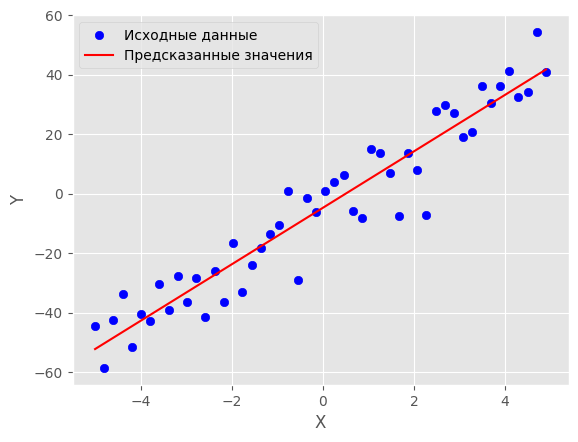

Train MSE: 72.37700200427633, Train MAE: 6.881929123175207
Test  MSE: 115.53404533196189, Test MAE: 8.581727516868545


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

X, X_train, y_train, X_test, y_test = generate_data(100)

X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

y_train_pred = X_train @ w

plt.scatter(X[0::2].reshape(-1,1), y_train, color='blue', label='Исходные данные')
plt.plot(X[0::2].reshape(-1,1), y_train_pred, color='red', label='Предсказанные значения')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Предсказание на тестовой выборке
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
y_test_pred = X_test @ w

mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Train MSE: {mse_train}, Train MAE: {mae_train}")
print(f"Test  MSE: {mse_test}, Test MAE: {mae_test}")


## Задание 3.2

Пример 2. Не всегда в задаче регрессии в качестве решения выступает прямая, как в предыдущем случае. Рассмотрим ещё один пример, в котором у объектов всё ещё один признак. Но теперь мы будм брать случайную точку на синусоиде и добавлять к ней шум — таким образом получим целевую переменную, признаком в этом случае будет координата $x$.

In [ ]:
def generate_wave_set(n_support=1000, n_train=25, std=0.3):
    data = {}
    # выберем некоторое количество точек из промежутка от 0 до 2*pi
    data['support'] = np.linspace(0, 2*np.pi, num=n_support)
    # для каждой посчитаем значение sin(x) + 1
    # это будет ground truth
    data['values'] = np.sin(data['support']) + 1
    # из support посемплируем некоторое количество точек с возвратом, это будут признаки
    data['x_train'] = np.sort(np.random.choice(data['support'], size=n_train, replace=True))
    # опять посчитаем sin(x) + 1 и добавим шум, получим целевую переменную
    data['y_train'] = np.sin(data['x_train']) + 1 + np.random.normal(0, std, size=data['x_train'].shape[0])
    return data

data = generate_wave_set(1000, 250)

Train MSE: 0.33, Train MAE: 0.48


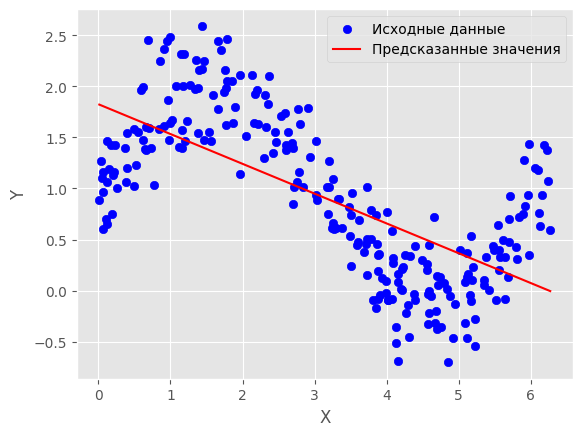

In [ ]:
### попробуйте реализовать настройку w и b с помощью рассмотренного выше метода наименьших квадратов.
### Найдите значения метрик MSE и MAE

X_train = data['x_train'].reshape(-1, 1)
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
y_train = data['y_train']

w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

y_train_pred = X_train @ w

mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"Train MSE: {mse_train:.2f}, Train MAE: {mae_train:.2f}")
plt.scatter(data['x_train'], data['y_train'], color='blue', label='Исходные данные')
plt.plot(data['x_train'], y_train_pred, color='red', label='Предсказанные значения')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Конечно, такое решение нас вряд ли может устроить. Нужно применить полинимиальную регрессию. Идея здесь такая. Каждый признак в исходную формулу может входить не только в первой степени, но и во второй, в третьей и так далее. То есть для случая, когда у нас только один признак:
$$ \widehat{y} = w_1 x_1 + w_2 x_1^2 + ... + w_k x_1^k + b,$$

## Задание 3.3

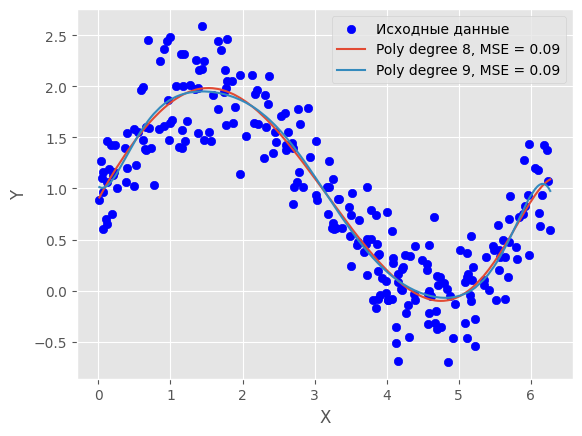

In [ ]:
### Реализуйте полиномиальную регрессию. Сделайте визуализацию для полиномов разных степеней.
### Полином какой степени подходит больше других? Почему?

import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error


X_train = data['x_train'].reshape(-1, 1)
y_train = data['y_train']

plt.scatter(X_train, y_train, label='Исходные данные', color='blue')

degrees = [i for i in range(8, 10)]  # степени полиномов

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X_train)

    w = np.linalg.inv(X_poly.T @ X_poly) @ X_poly.T @ y_train

    y_pred = X_poly @ w

    # сортировка данных для красивой отрисовки
    sort_indices = X_train[:, 0].argsort()
    X_train_sorted = X_train[sort_indices]
    y_pred_sorted = y_pred[sort_indices]

    # рассчитываем MSE для каждой степени полинома
    mse = mean_squared_error(y_train, y_pred)

    plt.plot(X_train_sorted, y_pred_sorted, label=f'Poly degree {degree}, MSE = {mse:.2f}')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


# Реальный датасет

Возьмём реальный набор данных Boston из sklearn.datasets. Этот датасет описывает средние цены на недвижимость в районах Бостона в тысячах долларов.

Примеры признаков объектов недвижимости: количество преступлений на душу населения, процент старых домов в районе, количество учеников на одного учителя и т.д. Обратите внимание на то, что данные уже оцифрованы там, где изначально признаки были качественными.

Загрузим датасет, выведем информацию

Возьмите датасет отсюда: https://www.kaggle.com/datasets/vikrishnan/boston-house-prices/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd


house_data = pd.read_csv("/content/drive/MyDrive/ITMO/5-sem/ml/boston.csv")
print(house_data.head())
X = house_data.drop(columns=['MEDV'])
y = house_data['MEDV']

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## Задание 3.4

In [ ]:
### оставьте в наборе данных только 7 наиболее значимых признаков
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_test_prediction_scaled = model.predict(X_test_scaled)
y_train_prediction_scaled = model.predict(X_train_scaled)

chosen_params = pd.DataFrame(index = X.columns, data = abs(model.coef_)).nlargest(7,0)
print(chosen_params)

                0
LSTAT    3.809214
DIS      3.075317
RM       2.813871
RAD      2.587977
TAX      2.182718
PTRATIO  2.021813
NOX      1.799117


In [ ]:
### настройте параметры линейной регрессии и сравните метрики качества (MSE и MAE) для полного датасета и усечённого
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train_scaled_chosen_params = pd.DataFrame(columns = X.columns, data = X_train_scaled)[chosen_params.index]
X_test_scaled_chosen_params = pd.DataFrame(columns = X.columns, data = X_test_scaled)[chosen_params.index]

model = LinearRegression()
model.fit(X_train_scaled_chosen_params, y_train)

y_train_prediction_scaled_chosen_params = model.predict(X_train_scaled_chosen_params)
y_test_prediction_scaled_chosen_params = model.predict(X_test_scaled_chosen_params)

print('            full_dataset           chosen_params')
print('Train MSE: ', mean_squared_error(y_train, y_train_prediction_scaled), '   ', mean_squared_error(y_train, y_train_prediction_scaled_chosen_params))
print('Test MSE:  ', mean_squared_error(y_test, y_test_prediction_scaled), '   ', mean_squared_error(y_test, y_test_prediction_scaled_chosen_params))
print('Train MAE: ', mean_absolute_error(y_train, y_train_prediction_scaled), '    ', mean_absolute_error(y_train, y_train_prediction_scaled_chosen_params))
print('Test MAE:  ', mean_absolute_error(y_test, y_test_prediction_scaled), '   ', mean_absolute_error(y_test, y_test_prediction_scaled_chosen_params))

            full_dataset           chosen_params
Train MSE:  21.638503748754324     24.072239933757473
Test MSE:   23.684410694831058     24.04791264419932
Train MAE:  3.258942703411837      3.52840955901572
Test MAE:   3.3511210700609673     3.301684661252019
